### Introduction
The Behavioral Risk Factor Surveillance System (BRFSS)[https://www.cdc.gov/brfss/data_documentation/index.htm] is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Since its creation by the U.S. Centers for Disease Control and Prevention (CDC) in
1984, the BRFSS has been conducted annually in all 50 states as well as the District of Columbia and three U.S. territories.

The BRFSS is aimed to answer state-level health-related questions. 
However, knowing the health conditions at finer scales, like county-level, can helpul. If we could use BRFSS data to get county-level estimates regarding to all the health-related questions, the benifits will be huge to not only the US goverments, but also health-care related companies. For example, goverments can identify counties with significant worse health conditions so polocies can be made to improve people's life. For health-care related companies, efficient marketing strategies can be proposed to better target their potential customers.

In this project, we will investigate the capacity of using BRFSS data to get county-level estimates. In this limited time, we only examine the BRFSS data for Missouri, where the author lives. The health-related question considered is the prevalence of colorectal cancer screening. Missouri has its own county-level estimates based on very large survey samples for counties in Missouri, which will be used as true values to evaluate our estimates from BRFSS.

### Data description
Colorectal cancer (CRC) is the third most commonly diagnosed 
cancer and the third leading cause of cancer death in both men 
and women in 
the U.S. CRC incidence rates 
increased from 1975 through the mid-1980s, but have since 
decreased with the 
exception of a slight, unexplained bump in rates between 1996 
and 1998. Declines have accelerated during the past few years. 
The incidence 
rates decreased by more than 4% from 2008 to 2010. The large 
declines over the past decade have largely been attributed to 
the detection 
and removal of polyps as a result of increased Colorectal cancer screening (CRCS). As 
for the mortality rates, they have been decreasing along with 
the 
incidence rates. From 2001 to 2010, CRC mortality rates 
decreased by about 3% per year, compared to declines of about 
2% per year in the 
1990s. The declines in mortality rates have been attributed to 
improvements in treatment, changing patterns in CRC risk factors 
and 
screening. CRCS plays an important role in the early detection of CRC, which can provide patients higher chance of survival. When screening identifies a colorectal tumor in its early stages, the cost of treatment is often much less expensive than if the tumor is detected later in the course of the disease. 

CRCS is important but unfortunately, not everyone takes the screening as recommended, which suggest people over 50 years old should take regular screenings. The possible reasons may include the unawareness of the screening, the cost of screening, the nature of the screening procedures (some people feels uncomfortable with them), etc. Knowing the current CRCS prevalence can be important for policymakers making plans to protect people against CRC. Efforts to promote CRCS are generally conducted locally, often at the level of the county or county equivalent. Counties with low CRCS prevalence should be monitored and policies should be made to encourage people to participate CRCS. However, estimates of CRCS prevalence are often available at the state level, not at finer scales like county level.

There are two kinds of regularly conducted surveys in Missouri which contain information about CRCS prevalence. One is the Behavioral Risk Factor Surveillance System (BRFSS) and the other one is Missouri County-Level Study.

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Since its creation by the U.S. Centers for Disease Control and Prevention (CDC) in
1984, the BRFSS has been conducted annually in all 50 states as well as the District of Columbia and three U.S. territories.
The Health and Behavioral Risk Research Center at the University of Missouri-Columbia collects BRFSS data for Missouri state.
To adjust the sampling bias and make sure the data collected are representative of the population for the state, raking (iterative proportional fitting) was used to accomplish this goal. The sample weight for a particular sample generated by raking can be interpreted as the inverse probability of a "likely" or "unlikely" the person been selected. 
For every two years, questions related to CRCS prevalence are asked in Missouri. For interviewers aged 50 and older, they were asked if they never had a sigmoidoscopy or colonoscopy, which are two major types of CRCS. Based on responses to this question, CRCS prevalence for Missouri can be obtained. 
We denote the Missouri BRFSS data as MO-BRFSS data. In 2012, there were 5,310 adults interviewed by randomly selected household landline telephone numbers. Additionally, 1,403 randomly selected adult cellphone-mostly users participated in the interview. A CRCS prevalence of 66.5% was reported for Missouri.

The Missouri County-level Study[http://health.mo.gov/data/cls/], which we denote as MO-CLS, followed standard CDC BRFSS methods and techniques. The questionnaire used for the interviews contains questions from the BRFSS and CDC Adult Tobacco Survey (ATS). Different from MO-BRFSS which only aims state-level estimates, MO-CLS aims at producing accurate county-level estimates by collecting much more data for each county. For example, the 2011 CLS goal was to complete 47,200 landline interviews with Missouri adults ages 18 and older. The goals were as follows:

* 800 interviews in Jackson County and St. Louis County with 400 interviews among African Americans and other races and 400 interviews among        *      whites.
* 800 interviews in St Louis City with 400 interviews among African Americans and 400 interviews among whites and other races.
* 400 completed interviews in the rest of 112 counties.

Additionally, a goal was established to obtain 4,720 interviews with adult cellphone-only users. Data from cell phone interviews were combined with landline data for analysis at the state and regional levels. Between January and December 2011, interviews were completed with 47,261 landline and 4,828 cell phone only users, totaling 52,089 completed interviews. The same raking method was used for MO-CLS to produce weighting variables. Note that the weighting variable in MO-BRFSS is to make survey sample represent the whole Missouri State, while the weighting variable in MO-CLS makes the survey sample represent each county in Missouri, which produce feasible ways to conduct county-level estimates.
For interviewers aged 50 and older, they were asked if they never had a sigmoidoscopy or colonoscopy, which is the same as the question asked in MO-BRFSS. At the state level, 2011 MO-CLS reported CRCS prevalence as 66%, which is close to 2012 MO-BRFSS result. The MO-CLS is ideal for producing county-level prevalence estimates, but it is conducted less frequently as MO-BRFSS. Currently, MO-CLS were only conducted for years 2003, 2007, 2011 and 2016.

### Survey sample distribution across counties in Missouri
We first check how samples are distributed across counties in Missouri.

In [1]:
#load packaged
library(sp);
library(rgeos)
library(maptools);
library(RColorBrewer)
library(dplyr)
library(gridExtra)
library(ggplot2)
library(ggmap)
library(sp);
library(rgeos)
library(maptools);
library(stringr)
library(sas7bdat)
library(Rcpp)
library(MCMCpack)
library(HI)

rgeos version: 0.3-19, (SVN revision 524)
 GEOS runtime version: 3.5.0-CAPI-1.9.0 r4084 
 Linking to sp version: 1.2-3 
 Polygon checking: TRUE 

Checking rgeos availability: TRUE

Attaching package: 'dplyr'

The following objects are masked from 'package:rgeos':

    intersect, setdiff, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: coda
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

##
## Markov Chain Monte Carlo Package (MCMCpack)
## Copyright (C) 2003-2017 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park
##
## Support provided by the U.S. National Science Foundation
## (Grants SES-0350646 and SES-0350613)
##


##### Read and Clean data
Since it is really prolong to clean the dataset. We put the code in another R file and just include it here.

In [2]:
source('clean_data.R')


 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or 'news(package="maps")'.  #




##### Produce the map for sample sizes

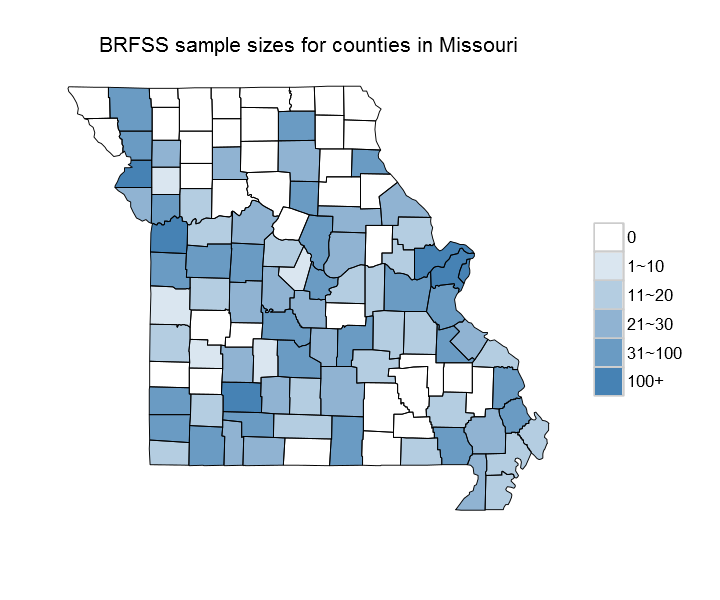

In [13]:
map_mo = map_data('county','missouri')
countyName = read.table('data/countyName.txt',sep=';')
countyName[,1] = as.character(countyName[,1])
get_county_fips = function(x){
  temp = unlist(strsplit(x,'='))
  temp = substr(temp[2], 3, 5)
  return(as.numeric(temp))
}
fips = as.numeric(sapply(countyName[,1],get_county_fips))
names = tolower(countyName[,2])
get_fips_data = function(map_mo,countyName,fips){
  n = length(countyName)
  df = data.frame(orders=1:n,
                  fips = fips,
                  subregion=countyName,
                  label = paste(1:n,countyName,sep='\n '))
  fips_data = merge(map_mo, df, sort = FALSE, by = "subregion")
  fips_data = fips_data[order(fips_data$order),]
  return(fips_data)
}
get_sp_data = function(map_mo,value, names){
  w_df = data.frame(value=value, subregion=names)
  sp_data = merge(map_mo, w_df, sort = FALSE, by = "subregion")
  sp_data = sp_data[order(sp_data$order),]
  return(sp_data)
}
#modify color
get_color = function(c_v){
  return(rgb(c_v[1], c_v[2], c_v[3]))
}
get_color_vector = function(z_min,z_max,z_mean,green_lim=NA){
  nin <- 256
  #nin <- 1000
  nzero <- floor(1 + nin*(z_mean - z_min)/(z_max-z_min))
  maxblue <- .7
  maxred  <- .7
  
  colors <- matrix(NA, nin, 3)
  colors[1:nzero,3] <- 1
  colors[1:nzero,2] <- seq(1 - maxblue, 1, length.out = nzero)
  colors[1:nzero,1] <- colors[1:nzero,2]
  ix <- (nzero+1):nin
  colors[ix, 1] <- 1
  colors[ix, 2] <- seq(1, 1 - maxred, length.out = nin - nzero)
  colors[ix, 3] <- colors[ix, 2]
  if(!is.na(green_lim)){
    colors[,2] <- seq(green_lim[1],green_lim[2], length.out = nin)
  }
  col_vector <- apply(colors, 1, get_color)
  return(col_vector)                 
}
#plot sample size
myPalette <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
sample_county = apply(n_mat, 1, sum)
sample_county_cat = cut(sample_county,breaks=c(-1,0,10,20,30,100,1000),include.lowest = TRUE)
levels(sample_county_cat) = c('0','1~10', '11~20', '21~30', '31~100', '100+')
sample_sp = get_sp_data(map_mo,sample_county_cat, names)

n_level = length(levels(sample_county_cat))
rbPal <- colorRampPalette(c("white","steelblue"))
color_vec = c('grey80', rbPal(n_level)[-1])
sample_plot = ggplot(sample_sp, aes(long, lat)) +
  geom_polygon(data=sample_sp,aes(group=group,fill=value)) +
  scale_fill_manual(values = rbPal(n_level))+
  geom_path(data=sample_sp,aes(group=group), colour = "black", size=0.2) +
  labs(fill='',x="",y="") +
  theme_bw() +
  theme(plot.title = element_text(size=12),
        strip.text.x = element_text(size = 16, colour = "black", angle = 0),
        legend.text = element_text(size=10),
        axis.text=element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        #strip.background = element_rect(fill="grey90"),
        legend.position = "right",
        strip.background = element_blank(),
        plot.margin = unit(c(0.1,0.1,0.1,0.1), "inch"),
        panel.border=element_blank(), axis.line=element_line(),axis.ticks=element_blank())+
  coord_map()+
  ggtitle('BRFSS sample sizes for counties in Missouri')
options(repr.plot.width=6, repr.plot.height=5)
print(sample_plot)

From the plot above, we can notice:

There are 37 counties in MO have zero sample (white color) and only 15 counties had more than 50 samples, where 50 is the minimum sample size that CDC will report the prevalence for a Chronic Disease indicator. Therefore, getting accurate county-level CRCS prevalence estimates is quite challenging.

### A baseline model using Bayesian techniques
Respondents in MO-BRFSS were classified into different categories based on their county at diagnosis, age (50--64, 65--74, 75+), gender (male, female) and race (white, non-white). For each county $i$, $i=1,..., I$ where $I=115$ in Missouri, the three age groups, two genders and two races yield twelve different categories. Let $J=12$ be the total number of categories and we use the following notations for each category $j$, $j=1, ..., J$, in county $i$:

* $n_{ij}$ : the MO-BRFSS sample size, which is the number of respondents;
* $y_{ij}$ : the number of respondents who have had CRCS out of all $n_{ij}$ respondents;
* $N_{ij}$ : the true population size based on 2010 Census data;	
* $Y_{ij}$ : the true population total who have had CRCS out of $N_{ij}$ people;
* $P_{ij}$ : the true proportion of people who have had CRCS.

The following Bayesian hierarchical model is used:

$$
y_{ij} \sim \text{Binomial}(n_{ij}, P_{ij}).
$$
$$
v_{ij}=\log(\frac{P_{ij}}{1-P_{ij}}) = \mu + \alpha_{r(i)} + \beta_j + \phi_1 x_{1i} + \phi_2 x_{2i} + \phi_3 x_{3i} + \phi_4 x_{4i} + u_i +
\epsilon_{ij},
$$
where

* $\mu$ is the overall intercept;
* $\alpha_{r(i)}$ is the regional effect of region $r(i)\in\{1, 2, ..., 7\}$ (recall that we have seven BRFSS regions for 2012 MO-BRFSS);
* $\beta_j$ is effect for the $j$th demographic category;
* $x_{1i}$ is the percentage of people below high school education level, with coefficient $\phi_1$;
* $x_{2i}$ is the percentage of people below 9th-grade education level, with coefficient $\phi_2$;
* $x_{3i}$ is the percentage of people above bachelor education level, with coefficient $\phi_3$;
* $x_{4i}$ is the median house income, with coefficient $\phi_4$;
* $u_i$ is a random spatial effect which accounts for extra county level variability not included in our model if exist; 
* $\epsilon_{ijkl}$ is the overdispersion  term accounting for extra variability not included in our model.

A proper Conditional Autoregressive prior is used on $u_i$. The remaining hyper priors are ommited here.


###### Load C++ functions for later use.

In [ ]:
sourceCpp('helper.cpp')

###### Start MCMC sampling algorithm

In [5]:
I = 115
J = n_class
n_sim = 10000

data_input = data.frame(y=c(y_mat), n=c(n_mat), brfss_region=rep(county2region_df$brfss_region, J),
                        below_high_school = rep(county_attributes$below_high_school, J),
                        below_9th = rep(county_attributes$below_9th, J),
                        above_bach = rep(county_attributes$above_bach, J),
                        median_income =rep( county_attributes$median_income, J),
                        sex = rep(class_dic$sex_vec,each=I),
                        age = rep(class_dic$age_vec,each=I),
                        race = rep(class_dic$race_vec,each=I),
                        class_category = rep(1:12, each=I)
)
brfss_region_factor = factor(data_input$brfss_region)
X_1 =  model.matrix(~brfss_region_factor+
                      factor(data_input$class_category)+
                      data_input$below_high_school + data_input$below_9th + data_input$above_bach+
                      data_input$median_income)
p = ncol(X_1)
mm = diag(I)
X_2 = matrix( rep( t( mm ) , J ) , ncol =  ncol(mm) , byrow = TRUE )
X = cbind(X_1, X_2)

v_post_full = matrix(0, n_sim, I*J)
r_post_full = matrix(0, n_sim, I+p)

v_prev  = rep(1, I*J)
r_prev = c(rep(0,p), rep(1, I))

v_post_full[1,] = v_prev
r_post_full[1,] = r_prev

delta0_post = numeric(n_sim)
eta1_post = numeric(n_sim)
delta1_post = numeric(n_sim)
rho_post = numeric(n_sim)

rho_post[1] = 0.1
delta0_post[1] = 0.2
eta1_post[1] = 1

a0=1
b0=1
delta_beta = 10000

egv = eigen(W)$values
rho_range = sort((1/egv[c(1,length(egv))]))
rho_min = rho_range[1]
rho_max = rho_range[2]

start = Sys.time()
for(i_sim in 2:n_sim){
  v_prev_vec = v_prev
  v_prev_mat = matrix(v_prev_vec, I, J)
  r_prev_vec = r_prev
  z_prev_vec = r_prev_vec[-(1:p)]
  z_prev_mat = matrix(z_prev_vec, I, J)
  delta0_prev = delta0_post[i_sim-1]
  Xr_prev = X%*%r_prev_vec
  Xr_prev_mat = matrix(Xr_prev, I, J)
  
  v_new_mat = sample_v(v_mat=v_prev_mat, y_mat=y_mat, n_mat=n_mat, z_mat=Xr_prev_mat, delta0=delta0_prev, 
                       xl=-6, xr=6, I=I, J=J)
  v_new_vec = c(v_new_mat)
  v_post_full[i_sim,] = v_new_vec
  
  r_new_vec = sample_r_sp(v_vec=v_new_vec, delta0=delta0_prev, rho=rho_post[i_sim-1], C=W, I=I, J=J,
                          p=p, X=X, delta_beta=delta_beta, eta1=eta1_post[i_sim-1])
  r_post_full[i_sim,] = r_new_vec
  z_new_vec = r_new_vec[-(1:p)]
  
  rho_new = sample_rho(xprev=rho_post[i_sim-1], w_vec=z_new_vec, C=W, nu_vec=egv, eta1=eta1_post[i_sim-1],
                       delta0=delta0_prev, K=I, 
                       rho_min=rho_min, rho_max=rho_max)
  rho_post[i_sim] = rho_new
  
  
  a = a0 + I*J/2 + I/2
  v_r = v_new_vec-X%*%r_new_vec
  IrhoC = diag(I) - rho_new*W
  b = b0 + 0.5 *t(v_r)%*%v_r + 0.5 * eta1_post[i_sim-1] * t(z_new_vec)%*%IrhoC%*%z_new_vec
  delta0_new = 1/rgamma(1,a,b)
  delta0_post[i_sim] = delta0_new

  eta1_post[i_sim] = sample_eta1_by_log(xprev=eta1_post[i_sim-1], w_vec=z_new_vec, C=W,
                                        rho=rho_post[i_sim], delta0=delta0_post[i_sim], K=I,xl=-20,xr=20)
  #update prev values
  v_prev = v_new_vec
  r_prev = r_new_vec
}
end = Sys.time()
#difftime(end, start, units='mins')

###### Based on the posterior samples of $\log(p_{ij})$, we can estimate the prevalence $P_i$ for each county.

In [6]:
part = 2001:n_sim
y_in_survey = apply(y_mat, 1, sum, na.rm = TRUE)
Nrest_county = apply(Nrest_mat, 1, sum)
posterior_samples = v_post_full[part,]
proportion_sample = matrix(NA, length(fips), dim(posterior_samples)[1])
for(i in 1:dim(posterior_samples)[1]){
  eta_sample_i = as.numeric(posterior_samples[i,])
  p_sample_i = exp(eta_sample_i)/(1+exp(eta_sample_i))
  p_sample_i_mat = matrix(p_sample_i, length(fips), length(class_names))
  p_county_i = (apply(p_sample_i_mat*Nrest_mat, 1, sum) + y_in_survey)/Nrest_county
  proportion_sample[,i] = p_county_i
}
p_mean_2 = apply(proportion_sample, 1, mean)

### Read into true values from Missouri CLS
How good are the estimates compared to Missouri CLS?
Read into the CLS estimate:

In [17]:
cls_data = read.csv('data/Missouri_CLS_modified.csv')
cls_data$Geography = tolower(cls_data$Geography)
#order the counties to have the same layout as we used in our analysis
cls_data[96:115,] = cls_data[c(97:115, 96),]
p_est_cls = 1-(cls_data$Prevalence....)/100

### Spatial plot
The following code generate prevalence maps from BRFSS and Missouri CLS. The spatial patterns between these two maps are similar. It is useful to examine county-level difference or patterns just using BRFSS data.

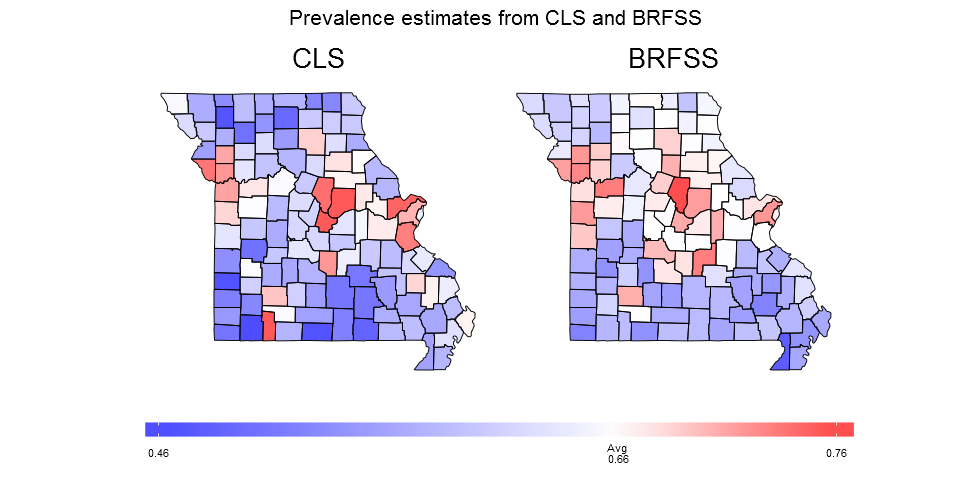

In [15]:
cls_sp = get_sp_data(map_mo,p_est_cls, names)
brfss_sp = get_sp_data(map_mo,p_mean_2, names)
all_p = c(p_est_cls, p_mean_2)
#combine two maps
cls_sp$id = 'CLS'
brfss_sp$id = 'BRFSS'
sp_data = rbind(cls_sp, brfss_sp)
#x_no_NA = p_est_cls#since cls is treated as true value, we use its scale
#statewide average rate based on p_est_cls
stage_avg = sum(N_county*p_est_cls)/sum(N_county)
color_vector = get_color_vector(min(all_p), max(all_p), stage_avg)
sp_data$id_f = factor(sp_data$id, levels = c('CLS', 'BRFSS'))

v_plot = ggplot(sp_data, aes(long, lat)) +
  facet_wrap(~id_f,ncol=2)+
  geom_polygon(data=sp_data,aes(group=group,fill=value)) +
  scale_fill_gradientn("",
                       colours = color_vector,
                       limits = c(min(all_p), max(all_p)),
                       breaks = c(min(all_p), stage_avg,max(all_p)),
                       labels = c(round(min(all_p),2), paste("Avg\n",round(stage_avg,2)), round(max(all_p),2)),
                       na.value = 'grey80')+
  geom_path(data=sp_data,aes(group=group), colour = "black", size=0.2) +
  labs(fill='',x="",y="") +
  theme_bw() +
  theme(plot.title = element_text(size=12),
        strip.text.x = element_text(size = 16, colour = "black", angle = 0),
        legend.text = element_text(size=6),
        axis.text=element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "bottom",
        strip.background = element_blank(),
        panel.border=element_blank(), axis.line=element_line(),axis.ticks=element_blank(),
        legend.key.height = unit(0.3, "cm"),
                                 legend.key.width = unit(3, "cm"),
                                 legend.margin = unit(0, "cm"),
                                 legend.position = "bottom",
                                 legend.text = element_text(size=10))+
  coord_map()+
  ggtitle('Prevalence estimates from CLS and BRFSS')
options(repr.plot.width=8, repr.plot.height=4)
print(v_plot)

### Scatter plot
We generate scatter plot between our estimate and the prevalence reported by Missouri CLS. The plot indicates our estimates generally agree with estimates from CLS.

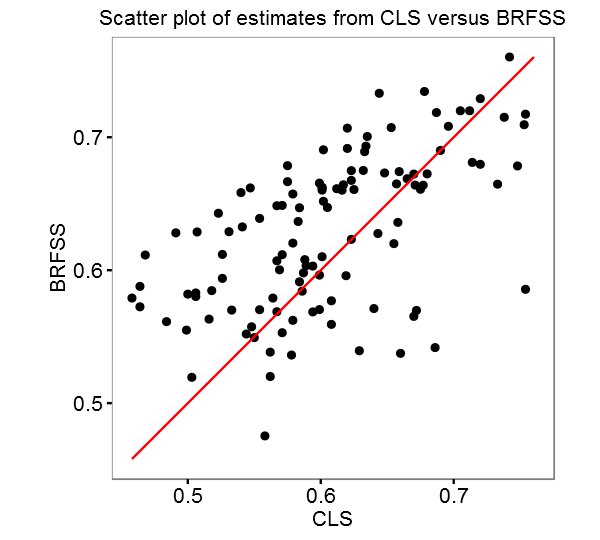

In [21]:
fake_p = seq(min(all_p),max(all_p),length.out = length(p_est_cls))
sample_county = apply(n_mat, 1, sum)
sample_county_cat = cut(sample_county,breaks=c(-1,0,10,20,30,100,1000),include.lowest = TRUE)
levels(sample_county_cat) = c('0','1~10', '11~20', '21~30', '31~100', '100+')
scatter_df = data.frame(cls = p_est_cls, brfss = p_mean_2, sample_size_cat = sample_county_cat, sample_size=sample_county,
                        fake_x = fake_p,fake_y = fake_p)

scatter_plot = ggplot(data=scatter_df, aes(x=p_est_cls, y=brfss))+
  geom_point(colour="black")+
  geom_line(aes(x=fake_x,y=fake_y),colour='red')+
  xlab('CLS')+
  ylab('BRFSS')+
  theme_bw()+
  coord_fixed()+
  theme(plot.title = element_text(size=12),
        strip.text.x = element_text(size = 7, colour = "black", angle = 0),
        legend.text = element_text(size=10),
        axis.text=element_text(size=12),
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        strip.background = element_rect(fill="grey90"),
        legend.position = "right")+
  ggtitle('Scatter plot of estimates from CLS versus BRFSS')
options(repr.plot.width=5, repr.plot.height=4.5)
print(scatter_plot)

### Conclusion
This base model shows the capacity of using BRFSS data to provide county-level estimates for all counties in the US. More variables can be collected and predictive models can be built using machine learning algorithms. We expect more accurate estimates if we are using data for all counties in the US, not just Missouri counties.